In [ ]:
import numpy as np
import yaml
import torch
import torch.nn as nn
import torch.nn.functional as F

from competence_estimation.utils import load_data, get_network_weights, mix_open
from competence_estimation.scores  import create_score_function
from competence_estimation.metrics  import compute_metric

import pandas as pd

import matplotlib.pyplot as plt

# Short Introduction

The following files are required:
* {x}_id_train.npy
* {x}_id_val.npy
* {x}_id_test.npy
where x = features, logits, labels

and the same for ood samples:
* {x}_ood
where x = features, logits, labels

Additionally we require the weights w and biases b of the last layer

# Data and Config Loading

In [ ]:
def calculate_fourier_spectrum(im, typ='MFS'):
    
    fft = np.fft.fft2(im)
    if typ == 'MFS':
        fourier_spectrum = np.abs(fft)
    elif typ == 'PFS':
        fourier_spectrum = np.abs(np.angle(fft))
        
    return fourier_spectrum

In [ ]:
with open("config.yml", "r") as file:
    config = yaml.safe_load(file)

In [ ]:
# Here you have to include your own path
# dataset_path = "/home/DATA/ITWM/lorenzp/"
dataset_path = "/home/lorenzp/workspace/competence_estimation/features/cifar10"
# algorithm = "ERM"
model = "resnet18"

w = np.load(f"{dataset_path}/{model}_W.npy")
b = np.load(f"{dataset_path}/{model}_b.npy")

# Features/logits/labels Trainings data
features_id_train =  np.load(f"{dataset_path}/features_{model}_train.npy")[:5000]
logits_id_train = np.load(f"{dataset_path}/logits_{model}_train.npy")[:5000]
labels_id_train =  np.load(f"{dataset_path}/labels_{model}_train.npy")[:5000]

# Features/logits/labels Validation data
features_id_val = np.load(f"{dataset_path}/features_{model}_test.npy")[:5000]
logits_id_val = np.load(f"{dataset_path}/logits_{model}_test.npy")[:5000]
labels_id_val = np.load(f"{dataset_path}/labels_{model}_test.npy")[:5000]

# Features/logits/labels Test data
features_id_test = np.load(f"{dataset_path}/features_{model}_test.npy")[5000:]
logits_id_test = np.load(f"{dataset_path}/logits_{model}_test.npy")[5000:]
labels_id_test = np.load(f"{dataset_path}/labels_{model}_test.npy")[5000:]

In [ ]:
w.shape

(10, 512)

In [ ]:
b.shape

(10,)

In [ ]:
features_id_train.shape

(5000, 512)

In [ ]:
np.squeeze(features_id_train).shape

(5000, 512)

In [ ]:
features_id_val.shape

(5000, 512)

In [ ]:
features_id_test.shape

(5000, 512)

In [ ]:
features_id_train = np.squeeze(features_id_train)
features_id_val = np.squeeze(features_id_val)
features_id_test = np.squeeze(features_id_test)

In [ ]:
logits_id_train.shape

(5000, 10)

In [ ]:
labels_id_train.shape

(5000,)

In [ ]:
# # typ = 'MFS'
# typ = 'PFS'
# features_id_train = calculate_fourier_spectrum(features_id_train, typ=typ)
# features_id_val   = calculate_fourier_spectrum(features_id_val, typ=typ)
# features_id_test  = calculate_fourier_spectrum(features_id_test, typ=typ)

# Score function creation

### "max_softmax", "max_logit", "vim", "mahalanobis", "knn", "energy", "energy_react", "GMM", "HBOS", "PCA"

In [30]:
score_function_name = 'vim' 

scores_id_val, score_function = create_score_function(
    features_id_train,
    logits_id_train,
    labels_id_train,
    features_id_val,
    logits_id_val,
    labels_id_val,
    w,
    b,
    score_function =  score_function_name,
    **config
)

In [31]:
scores_id_val

array([-0.53541446, -0.65919566, -0.07774067, ..., -0.7098379 ,
       -1.7891219 , -2.199666  ], dtype=float32)

In [ ]:
score_function

<function competence_estimation.scores.create_score_function.<locals>.score_function(features, logits)>

## Compute various scores and metrics

In [33]:
scores_id_train = score_function(features_id_train, logits_id_train)
scores_id_test  = score_function(features_id_test, logits_id_test)

scores_id_train

array([-0.62244916, -0.0029006 , -1.9743159 , ..., -0.98789096,
        0.5329118 , -2.0462205 ], dtype=float32)

In [34]:
scores_id_test

array([-2.1112394, -0.5813067,  2.4081006, ..., -2.6079154, -0.9722705,
       -0.6477413], dtype=float32)

In [45]:
# Here you would compute the scores for OOD data
# Features/logits/labels Validation data
attack = 'linfpgd'
# attack = 'fgsm'
# attack = 'l2df'
# attack = 'linfdf'

features_ood = np.squeeze(np.load(f"{dataset_path}/features_{attack}_{model}_test.npy"))[5000:8000]
logits_ood = np.load(f"{dataset_path}/logits_{attack}_{model}_test.npy")[5000:8000]
labels_ood = np.load(f"{dataset_path}/labels_{attack}_{model}_test.npy")[5000:8000]

In [46]:
features_ood.shape

(3000, 512)

In [47]:
logits_ood.shape

(3000, 10)

In [48]:
labels_ood.shape

(3000,)

In [49]:
scores_ood_test = score_function(features_ood, logits_ood)

In [50]:
metrics = ['quantiles']

outs = compute_metric(
    scores_id_val,
    scores_id_test,
    scores_ood_test,
    features_id_train,
    logits_id_train,
    labels_id_train,
    features_id_test,
    logits_id_test,
    labels_id_test,
    features_ood,
    logits_ood,
    labels_ood,
    metrics=metrics
)

In [51]:
#n_95 is the accuracy at threshold 95%percentile of validation set
#n_95_frac is the fraction of included samples at this particular threshold
print(outs)

{'n_95_frac': 0.0, 'n_95': nan}


In [62]:
# load_fourier = False
load_fourier = False
typ = "MFS"
# typ = "PFS"

calc_fourier = False

#assert (load_fourier != calc_fourier)
# typ = ""

# Here you have to include your own path
# dataset_path = "/home/DATA/ITWM/lorenzp/"
dataset_path = "/home/lorenzp/workspace/competence_estimation/features/cifar10"
# algorithm = "ERM"
model = "resnet18"

w = np.load(f"{dataset_path}/{model}_W.npy")
b = np.load(f"{dataset_path}/{model}_b.npy")


load_data = "{}".format(model)
if load_fourier:
    load_data = typ + '_' + load_data

# Features/logits/labels Trainings data
features_id_train =  np.load(f"{dataset_path}/features_{load_data}_train.npy")[:5000]
logits_id_train = np.load(f"{dataset_path}/logits_{load_data}_train.npy")[:5000]
labels_id_train =  np.load(f"{dataset_path}/labels_{load_data}_train.npy")[:5000]

# Features/logits/labels Validation data
features_id_val = np.load(f"{dataset_path}/features_{load_data}_train.npy")[5000:10000]
logits_id_val = np.load(f"{dataset_path}/logits_{load_data}_train.npy")[5000:10000]
labels_id_val = np.load(f"{dataset_path}/labels_{load_data}_train.npy")[5000:10000]

# Features/logits/labels Test data
features_id_test = np.load(f"{dataset_path}/features_{load_data}_test.npy")[10000:15000]
logits_id_test = np.load(f"{dataset_path}/logits_{load_data}_test.npy")[10000:15000]
labels_id_test = np.load(f"{dataset_path}/labels_{load_data}_test.npy")[10000:15000]


# # Features/logits/labels Validation data
# features_id_val = np.load(f"{dataset_path}/features_{load_data}_test.npy")[:5000]
# logits_id_val = np.load(f"{dataset_path}/logits_{load_data}_test.npy")[:5000]
# labels_id_val = np.load(f"{dataset_path}/labels_{load_data}_test.npy")[:5000]

# # Features/logits/labels Test data
# features_id_test = np.load(f"{dataset_path}/features_{load_data}_test.npy")[5000:]
# logits_id_test = np.load(f"{dataset_path}/logits_{load_data}_test.npy")[5000:]
# labels_id_test = np.load(f"{dataset_path}/labels_{load_data}_test.npy")[5000:]

metrics = ['quantiles']
results = {}
attacks = ['nor', 'fgsm', 'linfpgd', 'linfdf', 'l2df']
score_fct = ["max_softmax", "max_logit", "vim", "mahalanobis", "knn", "energy", "energy_react", "GMM",  "PCA"]
# attacks = ['pgd']
# score_fct = [ "vim" ]


if calc_fourier: 
    features_id_train = calculate_fourier_spectrum(features_id_train, typ=typ)
    features_id_val = calculate_fourier_spectrum(features_id_val, typ=typ)
    features_id_test = calculate_fourier_spectrum(features_id_test, typ=typ)


for it, attack in enumerate(attacks):
    print("attack: ", attack)
    results[attack] = {}
    
    if it == 0:
        print("it", it)
        features_ood = features_id_test     
        logits_ood =   logits_id_test   
        labels_ood =   labels_id_test    
    else:
        features_ood = np.squeeze(np.load(f"{dataset_path}/features_{attack}_{load_data}_test.npy"))[5000:8000]
        logits_ood = np.load(f"{dataset_path}/logits_{attack}_{load_data}_test.npy")[5000:8000]
        labels_ood = np.load(f"{dataset_path}/labels_{attack}_{load_data}_test.npy")[5000:8000]
    
    if calc_fourier: 
        features_ood = calculate_fourier_spectrum(features_ood, typ=typ)
    scores_ood_test = score_function(features_ood, logits_ood)
    
    for it2, score_function_name in enumerate(score_fct):
        scores_id_val, score_function = create_score_function(
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_val,
            logits_id_val,
            labels_id_val,
            w,
            b,
            score_function =  score_function_name,
            **config
        )
        scores_id_train = score_function(features_id_train, logits_id_train)
        scores_id_test  = score_function(features_id_test, logits_id_test)
                                         
        outs = compute_metric(
            scores_id_val,
            scores_id_test,
            scores_ood_test,
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_test,
            logits_id_test,
            labels_id_test,
            features_ood,
            logits_ood,
            labels_ood,
            metrics=metrics
        )

        print(score_function_name, outs)
        results[attack][score_function_name] = outs['n_95_frac']
        
keys = list(results.keys())
methods  = list(results[keys[0]].keys())
        
table = {}

for method in methods: 
    table[method] = []
    
    for  key in keys:
        table[method].append(results[key][method])

attack:  nor
it 0


ValueError: Found array with 0 sample(s) (shape=(0, 512)) while a minimum of 1 is required by PCA.

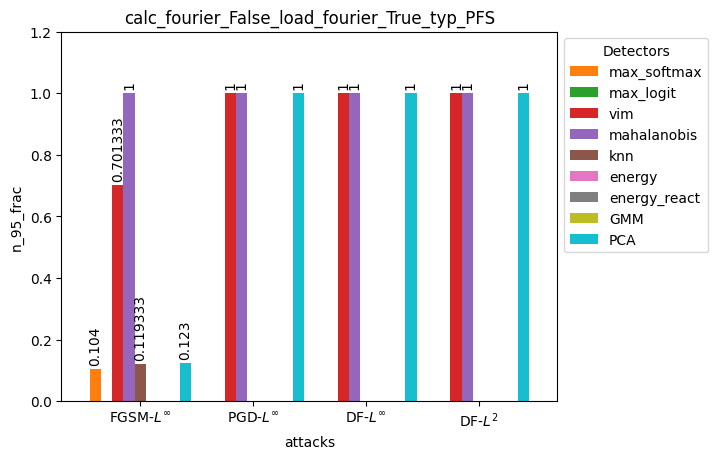

In [53]:
raw_data = {
    'plan_type':  ['FGSM-$L^\infty$', 'PGD-$L^\infty$', 'DF-$L^\infty$', 'DF-$L^2$'],
}

for method in methods:
    raw_data[ method] = table[method]

df = pd.DataFrame(raw_data, columns=methods)
ax = df.plot.bar(rot=0, color=["#ff7f0e", "#2ca02c", '#d62728', '#9467bd', "#8c564b", "#e377c2", '#7f7f7f', '#bcbd22', '#17becf'], width=0.9)

for p in ax.patches[0:]:
    h = p.get_height()
    x = p.get_x()+p.get_width()/2.
    if h != 0:
        ax.annotate("%g" % p.get_height(), xy=(x, h), xytext=(0, 3), rotation=90, 
                   textcoords="offset points", ha="center", va="bottom")

plt.title("calc_fourier_{}_load_fourier_{}_typ_{}".format(calc_fourier, load_fourier, typ))
      
ax.set_ylim(0, 1.2)
ax.legend(title="Detectors", bbox_to_anchor=(1.0, 1), loc='upper left')
ax.set_xticklabels(raw_data["plan_type"])
plt.xlabel("attacks")
plt.ylabel("n_95_frac")

plt.savefig("figures/calc_fourier_{}_load_fourier_{}_typ_{}".format(calc_fourier, load_fourier, typ), bbox_inches='tight', dpi=300)

In [43]:
# load_fourier = False
load_fourier = True
typ = "MFS"
# typ = "PFS"

calc_fourier = False
# typ = ""

# Here you have to include your own path
# dataset_path = "/home/DATA/ITWM/lorenzp/"
dataset_path = "/home/lorenzp/workspace/competence_estimation/features/cifar10"
# algorithm = "ERM"
model = "resnet18"

w = np.load(f"{dataset_path}/{model}_W.npy")
b = np.load(f"{dataset_path}/{model}_b.npy")


load_data = "{}".format(model)
if load_fourier:
    load_data = typ + '_' + load_data
    
print("load_data", load_data)

# Features/logits/labels Trainings data
features_id_train = np.load(f"{dataset_path}/features_{load_data}_train.npy")[:5000]
logits_id_train   = np.load(f"{dataset_path}/logits_{load_data}_train.npy")[:5000]
labels_id_train   = np.load(f"{dataset_path}/labels_{load_data}_train.npy")[:5000]

# Features/logits/labels Validation data
features_id_val = np.load(f"{dataset_path}/features_{load_data}_test.npy")[:5000]
logits_id_val   = np.load(f"{dataset_path}/logits_{load_data}_test.npy")[:5000]
labels_id_val   = np.load(f"{dataset_path}/labels_{load_data}_test.npy")[:5000]

# Features/logits/labels Test data
features_id_test = np.load(f"{dataset_path}/features_{load_data}_test.npy")[5000:]
logits_id_test   = np.load(f"{dataset_path}/logits_{load_data}_test.npy")[5000:]
labels_id_test   = np.load(f"{dataset_path}/labels_{load_data}_test.npy")[5000:]

load_data MFS_resnet18


In [44]:
metrics = ['quantiles']
results = {}
attacks = ['linfpgd', 'fgsm', 'l2df', 'linfdf']
# score_fct = ["max_softmax", "max_logit", "vim", "mahalanobis", "knn", "energy", "energy_react", "GMM",  "PCA"]
# attacks = ['pgd']
score_fct = ["vim" ]


if calc_fourier: 
    features_id_train = calculate_fourier_spectrum(features_id_train, typ=typ)
    features_id_val = calculate_fourier_spectrum(features_id_val, typ=typ)
    features_id_test = calculate_fourier_spectrum(features_id_test, typ=typ)


for it, attack in enumerate(attacks):

    print("attack: ", attack)
    results[attack] = {}

    features_ood = np.squeeze(np.load(f"{dataset_path}/features_{attack}_{load_data}_test.npy"))[5000:8000]
    logits_ood = np.load(f"{dataset_path}/logits_{attack}_{load_data}_test.npy")[5000:8000]
    labels_ood = np.load(f"{dataset_path}/labels_{attack}_{load_data}_test.npy")[5000:8000]
    
    if calc_fourier: 
        features_ood = calculate_fourier_spectrum(features_ood, typ=typ)
    scores_ood_test = score_function(features_ood, logits_ood)
    
    for it2, score_function_name in enumerate(score_fct):
        scores_id_val, score_function = create_score_function(
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_val,
            logits_id_val,
            labels_id_val,
            w,
            b,
            score_function =  score_function_name,
            **config
        )
        scores_id_train = score_function(features_id_train, logits_id_train)
        scores_id_test  = score_function(features_id_test, logits_id_test)
                                         
        outs = compute_metric(
            scores_id_val,
            scores_id_test,
            scores_ood_test,
            features_id_train,
            logits_id_train,
            labels_id_train,
            features_id_test,
            logits_id_test,
            labels_id_test,
            features_ood,
            logits_ood,
            labels_ood,
            metrics=metrics
        )

        print(score_function_name, outs)
        results[attack][score_function_name] = outs['n_95_frac']
        
# keys = list(results.keys())
# methods  = list(results[keys[0]].keys())
        
# table = {}

# for method in methods: 
#     table[method] = []
    
#     for  key in keys:
#         table[method].append(results[key][method])

attack:  linfpgd
vim {'n_95_frac': 1.0, 'n_95': 0.09733333438634872}
attack:  fgsm
vim {'n_95_frac': 0.7013333333333334, 'n_95': 0.1278517097234726}
attack:  l2df
vim {'n_95_frac': 0.6706666666666666, 'n_95': 0.1312127262353897}
attack:  linfdf
vim {'n_95_frac': 0.6663333333333333, 'n_95': 0.1320660263299942}
